In [2]:
# import the required packages
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
from PIL import Image

In [3]:
# Boolean variable in order to not build the data more than once (just load it if you did before)
REBUILD_DATA = False # Set it to true once!!

# Function to convert rgb images to gray scale
# source : https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Use the gpu if there's Cuda and a compatiable GPU with it. Otherwise, use the CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

class StreetSigns():
    imageSize = 50
    labels = []
    trainingData = []
    def makeTrainingData(self, rootpath):
        # using tqdm to enable the nice view of a loading bar
        for c in tqdm(range(0,43)):
            # Get the directory for the images 
            prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
            gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            next(gtReader) # skip header
            # loop over all images in current annotations file
            for row in gtReader:
                img = plt.imread(prefix + row[0])
                img = cv2.resize(img, (self.imageSize, self.imageSize))
                img = np.array(img)
                img = rgb2gray(img) #tranform it to gray scale 
                label = int(row[7])
                self.labels.append(label) # the 8th column is the label
                '''
                Here I am using hot vectors (let's say the image belongs to the 5th label, so the 
                second list to store would be [0,0,0,0,1,....,0])
                '''
                self.trainingData.append([np.array(img), np.eye(43)[label]])

            gtFile.close()
                
        # Shuffle our training data        
        np.random.shuffle(self.trainingData)
        np.save("StreetSignsData.npy", self.trainingData)
        
# check if we need to rebuild the data and do so if needed        
if REBUILD_DATA:
    streetSigns = StreetSigns()
    streetSigns.makeTrainingData("GermanDataset\\GTSRB_Final_Training_Images\\GTSRB\\Final_Training\\Images")

Running on the GPU


In [4]:
# load the training data
trainingData = np.load("StreetSignsData.npy", allow_pickle = True)
# print some samples to make sure we are doing fine
print(len(trainingData))
print(trainingData[1])

39209
[array([[105.7139, 102.1873, 103.3012, ..., 109.7673, 106.6967, 104.2239],
       [109.1588, 106.5181, 105.2193, ..., 110.7672, 108.8814, 104.8818],
       [105.6645, 104.1377, 104.1377, ..., 112.066 , 111.7671, 107.3546],
       ...,
       [103.4367, 103.0669,  97.3556, ..., 111.1262, 119.8803, 115.9346],
       [105.6429,  99.8715,  93.5732, ..., 115.3538, 116.4076, 107.4516],
       [ 99.3338,  94.9752,  89.9757, ..., 112.995 , 102.295 ,  92.2852]])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0.])]


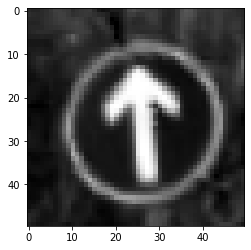

In [4]:
# Let's show a picture
plt.imshow(trainingData[1][0], cmap="gray")
plt.show()

In [5]:
# Our Neural Netowrk Class
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Kernel/Window size is 5
        
        # here we have 3 layers
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x) # part of the forward
        
        # and two activation functions
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 43)
        
    # transform our image to an approeriate way for our neurons   
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))        
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [6]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
lossFunction = nn.CrossEntropyLoss()
# x is storing the data, y is storing the correspondant data
x = torch.Tensor([i[0] for i in trainingData]).view(-1, 50, 50).long()
x = x/255.0 # normalize the values to be in range [0,1]
y = torch.Tensor([i[1] for i in trainingData]).long()
valPct = 0.1
valSize = int(len(x)*valPct)
print(valSize)

trainX = x[:-valSize]
trainY = y[:-valSize]

testX = x[-valSize:]
testY = y[-valSize:]

print(len(trainX))
print(len(testX))

3920
35289
3920


In [7]:
batchSize = 100
epochs = 9
def train(net):
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    lossFunction = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for i in tqdm(range(0, len(trainX), batchSize)):
            #print(i, i + batchSize)
            batchX = trainX[i:i+batchSize].view(-1,1,50,50)
            batchY = trainY[i:i+batchSize]
            
            batchX, batchY = batchX.to(device), batchY.to(device)
            
            net.zero_grad() # or optimizer.zero_grad because 1 optimizer exists
            outputs = net(batchX)
            loss = lossFunction(outputs, batchY)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch: {epoch}, Loss: {loss}")
        

In [8]:
def test(net):
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(testX))):
            # take out the right answer and the predicted answer to compare them
            realClass = torch.argmax(testY[i]).to(device) 
            netOut = net(testX[i].view(-1,1,50,50).to(device))[0]
            predictedClass = torch.argmax(netOut)
            if predictedClass == realClass:
                correct += 1
            total += 1
    print("Accurancy:", round(correct/total,3))

In [9]:
def forwardPass(x, y, train = False):
    if train: # if we are in training mode, we have to reset the gradient for calculations
        net.zero_grad()
    outputs = net(x)
    # count the matches to find the accurancy ratio and the loss
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs,y)]
    acc = matches.count(True)/len(matches)
    loss = lossFunction(outputs, y.argmax(dim = 1))
    # if we are training, do back propegation
    if train:
        loss.backward()
        optimizer.step()
        
    return acc, loss

In [10]:
import numpy as np

# when testing, I took a random chuck from the data and compared the results
def test(size=32):
    randomStart = np.random.randint(len(testX)-size)
    x, y = testX[randomStart:randomStart + size], testY[randomStart:randomStart+size]
    with torch.no_grad():
        valAcc, valLoss = forwardPass(x.view(-1,1,50,50).to(device), y.to(device))
    return valAcc, valLoss

valAcc, valLoss = test(size=32)

In [15]:
''' (Delete the current model log file before running this code) '''
import time
from tqdm import tqdm
# store the info to our log file (Delete the current file before running this code)
modelName = f"model-{int(time.time())}"
myAcc = []
myLoss = []
myTime = []

net = Net().to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.001)
lossFunction = nn.CrossEntropyLoss()

# after each epoch, calcualte the loss and the accurancy to plot changes at the end

def train():
    global myAcc
    global myTime
    global myLoss
    batchSize = 50
    epochs = 3
    with open("model.log", "a") as f:
        for epoch in range(epochs):
            for i in tqdm(range(0, len(trainX), batchSize)):
                batchX = trainX[i:i+batchSize].view(-1,1,50,50).to(device)
                batchY = trainY[i:i+batchSize].to(device)
                
                acc, loss = forwardPass(batchX, batchY, train = True)
                if i % 25 == 0:
                    valAcc, valLoss = test(size=50)
                    f.write(f"{modelName},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(valAcc),2)},{round(float(valLoss),4)}\n")
            
            valAcc, valLoss = test(size=50)
            myTime.append(epoch)
            myAcc.append(valAcc)
            myLoss.append(valLoss)
train()
                
                

100%|████████████████████████████████████████████████████████████████████████████████| 706/706 [01:40<00:00,  7.01it/s]


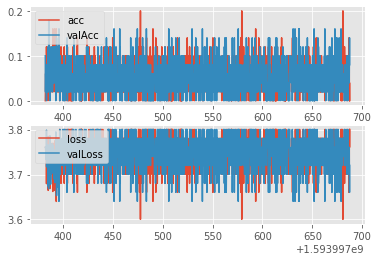

In [20]:
import matplotlib.pyplot as plt
from matplotlib import style

# create a simple graph for model analysis
# if you run it in an IDE, you will have more controls over the graph such as zooming
style.use("ggplot")

# we already have the variable modelName

def createAccLossGraph(modelName):
    contents = open("model.log", "r").read().split('\n')
    
    times = []
    accuarncies = []
    losses = []
    
    valAccs = []
    valLosses = []
    
    for c in contents:
        if modelName in c:
            name, timestamp, acc, loss, valAcc, ValLoss = c.split(",")
            
            times.append(float(timestamp))
            accuarncies.append(float(acc))            
            losses.append(float(loss))
            
            valAccs.append(float(valAcc))            
            valLosses.append(float(ValLoss))
            
    fig = plt.figure() #because we need more than one plot, if we need we would use plt.plot
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex = ax1)
    
    ax1.plot(times, accuarncies, label="acc")
    ax1.plot(times, valAccs, label="valAcc")
    ax1.legend(loc=2)
    
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, valLosses, label="valLoss")
    ax2.legend(loc=2)
    
    #debug

    plt.show()

    
createAccLossGraph(modelName)
    

[0, 1, 2]


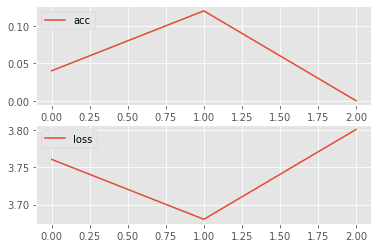

In [19]:
import matplotlib.pyplot as plt
from matplotlib import style

# create a simple graph for model analysis
# if you run it in an IDE, you will have more controls over the graph such as zooming
style.use("ggplot")

# we already have the variable modelName

def createAccLossGraph2(modelName):
    times = myTime
    accuarncies = myAcc
    losses = myLoss   
    print(times)
    fig = plt.figure() #because we need more than one plot, if we need we would use plt.plot
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex = ax1)
    
    ax1.plot(times, accuarncies, label="acc")
    ax1.legend(loc=2)
    
    ax2.plot(times, losses, label="loss")
    ax2.legend(loc=2)
    
    #debug

    plt.show()

    
createAccLossGraph2(modelName)
    

In [38]:
REBUILD_DATA_TEST = True # Set it to true once!!

class TestStreetSigns():
    imageSize = 50
    labels = []
    testData = []
    def makeTestData(self, rootpath):
        # using tqdm to enable the nice view of a loading bar
        # Get the directory for the images 
        prefix = rootpath # subdirectory for class
        with open(prefix + 'GT-final_test.csv', 'r') as gtFile:
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            next(gtReader) # skip header
            # loop over all images in current annotations file
            for row in gtReader:
                img = plt.imread(prefix + row[0])
                img = cv2.resize(img, (self.imageSize, self.imageSize))
                img = np.array(img)
                img = rgb2gray(img) #tranform it to gray scale 
                label = int(row[7])
                self.labels.append(label) # the 8th column is the label
                '''
                    Here I am using hot vectors (let's say the image belongs to the 5th label, so the 
                    second list to store would be [0,0,0,0,1,....,0])
                '''
                self.testData.append([np.array(img), np.eye(43)[label]])

            gtFile.close()
                
        # Shuffle our training data        
        np.random.shuffle(self.testData)
        np.save("StreetSignsTest.npy", self.testData)
        
# check if we need to rebuild the data and do so if needed        
if REBUILD_DATA_TEST:
    TestStreetSigns = TestStreetSigns()
    TestStreetSigns.makeTestData("GermanDataset\\GTSRB_Final_Test_Images\GTSRB\\Final_Test\\Images\\")

In [39]:
# load the training data
testingData = np.load("StreetSignsTest.npy", allow_pickle = True)
# print some samples to make sure we are doing fine
print(len(testingData))
print(testingData[1])

12630
[array([[145.2263, 141.9878, 135.1734, ..., 137.315 , 135.0271, 133.6251],
       [145.6284, 142.6996, 137.4829, ..., 137.3258, 134.8422, 134.4401],
       [145.2263, 143.5038, 139.0806, ..., 136.6248, 133.5434, 133.9563],
       ...,
       [113.7455, 114.4619, 137.3778, ..., 141.2329, 145.0476, 140.102 ],
       [120.4567, 117.8745, 135.2963, ..., 148.4109, 144.5037,  61.2283],
       [125.2282, 127.0046, 130.286 , ..., 151.1117, 104.2843,  40.4736]])
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0.])]


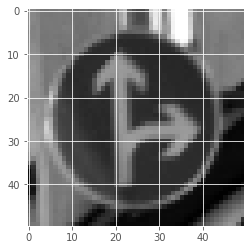

In [40]:
# Let's show a picture
plt.imshow(testingData[1][0], cmap="gray")
plt.show()

In [41]:
# x is storing the data, y is storing the correspondant data
testX = torch.Tensor([i[0] for i in testingData]).view(-1, 50, 50).long()
testX = x/255.0 # normalize the values to be in range [0,1]
testY = torch.Tensor([i[1] for i in testingData]).long()
valPct = 0.1
valSize = int(len(x)*valPct)
print(valSize)

1263
11367
1263


In [62]:
def testAll():
    totalAcc = 0
    totalLoss = 0
    total = 0
    batchSize = 50
    for i in tqdm(range(0, len(testX), batchSize)):
        batchX = testX[i:i+batchSize].view(-1,1,50,50).to(device)
        batchY = testY[i:i+batchSize].to(device)          
        acc, loss = forwardPass(batchX, batchY, train = False)
        totalAcc += acc
        totalLoss += loss
        total += 1
    print(totalAcc/total)
    print(totalLoss)

4.908946951702296
3.7611145973205566
